### **CS74 Final Project, Amazon Product Classifications & Clustering**

In [67]:
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import autograd.numpy as np 
from scipy.sparse import hstack
from warnings import simplefilter
import matplotlib.pyplot as plt
# ignore all warnings
simplefilter(action='ignore')


In [68]:
train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('Test.csv')

In [69]:
# function for labelling
def label(rating, cutoff):
    return 0 if rating <= cutoff else 1

In [70]:
#labeling depending on cutoff
for cutoff in [1, 2, 3, 4]:
    train_data['label_' + str(cutoff)] = train_data['overall'].apply(lambda x: label(x, cutoff))

#### Feature Selection

In [71]:
#Data pre-processing & Feature Engineering
train_data.fillna('', inplace=True)  # fill in missing values with empty strings
test_data.fillna('', inplace=True)  

#vectorize training and testing data
vectorizer1 = TfidfVectorizer(ngram_range=(1, 2)) # best is bigrams for macro f1
summary_vector = vectorizer1.fit_transform(train_data['summary'])
test_summary_vector = vectorizer1.transform(test_data['summary'])

vectorizer2 = TfidfVectorizer(ngram_range=(1, 2)) #best is (1,2)
review_vector = vectorizer2.fit_transform(train_data['reviewText'])
test_review_vector = vectorizer2.transform(test_data['reviewText'])

vectorizer3 = TfidfVectorizer()
verified_vector = vectorizer3.fit_transform(train_data['verified'].astype(str))
test_verified_vector = vectorizer3.fit_transform(test_data['verified'].astype(str))

vectorizer4 = TfidfVectorizer()
category_vector = vectorizer4.fit_transform(train_data['category'])
test_category_vector = vectorizer4.fit_transform(test_data['category'])

vectorizer5 = TfidfVectorizer()
image_vector = vectorizer5.fit_transform(train_data['image'])
test_image_vector = vectorizer5.transform(test_data['image'])



# stack the vectors to one vector; best way to show feature vectors
train_vectors = hstack([summary_vector, review_vector, category_vector, image_vector, verified_vector])
Kaggle_test_vectors = hstack([test_summary_vector, test_review_vector, test_category_vector, test_image_vector, test_verified_vector])



In [72]:
#function for hyperparameter tuning
def tune_parameters(clf, param_grid, x, y):
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro')
    print("Fitting Grid for Tuning....")
    grid_search.fit(x, y)
    print('Grid fitted')
    means = grid_search.cv_results_['mean_test_score']
    params = grid_search.cv_results_['params']
    for mean, params in zip(means, params):
        print('CVscore: means to params: ', mean, params)
    print("Best hyperparameters:", grid_search.best_params_)
    return grid_search

### **Binary Classification**

In [73]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, accuracy_score, classification_report
def evaluate_classifier(clf, param_grid, train_vectors, train_labels, test_vectors, test_labels, kaggle=None):
    best_params = tune_parameters(clf, param_grid, train_vectors, train_labels).best_params_

    # Train the classifier with the tuned hyperparameters
    clf.set_params(**best_params)
    clf.fit(train_vectors, train_labels)
    pred_labels = clf.predict(test_vectors)

    # evaluations
    print("Confusion Matrix:\n", confusion_matrix(test_labels, pred_labels))
    print("Report on Validation Set: \n", classification_report(test_labels, pred_labels))
    accuracy = accuracy_score(test_labels, pred_labels)
    print("Accuracy:", accuracy)

    f1_macro = f1_score(test_labels, pred_labels, average='macro')
    print("Macro F1 score:", f1_macro)

    fpr, tpr, thresholds = roc_curve(test_labels, pred_labels)
    roc_auc = auc(fpr, tpr)
    print("ROC AUC:", roc_auc)
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    if kaggle != None: #return prediction on test.csv if given 
        kaggle_pred = clf.predict(kaggle)
        return kaggle_pred
    


In [74]:
def LRClassifier(cutoff):
    
    print("Cutoff:", cutoff)
    train_labels = train_data['label_' + str(cutoff)]
    X_train, X_test, y_train, y_test = train_test_split(train_vectors, train_labels, test_size=0.1, random_state=42)
    print("Logistic Regression: ")
    clf = LogisticRegression()
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    kaggle_pred = evaluate_classifier(clf, param_grid, X_train, y_train, X_test, y_test, Kaggle_test_vectors)
    return kaggle_pred
    


In [34]:
def NBClassifier(cutoff):

    print("Cutoff:", cutoff)
    train_labels = train_data['label_' + str(cutoff)]
    X_train, X_test, y_train, y_test = train_test_split(train_vectors, train_labels, test_size=0.2, random_state=42) 
    print("Naive Bayes:")
    clf = MultinomialNB()
    param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
    pred = evaluate_classifier(clf, param_grid, X_train, y_train, X_test, y_test, Kaggle_test_vectors)
    return pred

In [35]:
def Perceptron_Classifier(cutoff):
    
    print("Cutoff:", cutoff)
    train_labels = train_data['label_' + str(cutoff)]
    X_train, X_test, y_train, y_test = train_test_split(train_vectors, train_labels, test_size=0.2, random_state=42)
    print("Perceptron:")
    clf = Perceptron()
    param_grid = {'class_weight': [None, 'balanced', {0:1, 1:10}]}
    pred = evaluate_classifier(clf, param_grid, X_train, y_train, X_test, y_test, Kaggle_test_vectors)
    return pred

In [75]:
# create csv file for kaggle
def showresults(funct, cutoff):
    test_predicted = funct(cutoff)
    test_ids = list(test_data.index)
    test_submission = pd.DataFrame({'id':test_ids, 'predicted':test_predicted})
    test_submission.head()
    test_submission.to_csv(str(funct.__name__)+ 'test_submission_part_' + str(cutoff)+'.csv', index=False)

Cutoff: 1
Logistic Regression: 
Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.5811611971931102 {'C': 0.01}
CVscore: means to params:  0.6243026815145498 {'C': 0.1}
CVscore: means to params:  0.7372055129540925 {'C': 1}
CVscore: means to params:  0.7715547054531472 {'C': 10}
CVscore: means to params:  0.77924792796149 {'C': 100}
Best hyperparameters: {'C': 100}
Confusion Matrix:
 [[ 336  266]
 [ 112 2205]]
Report on Validation Set: 
               precision    recall  f1-score   support

           0       0.75      0.56      0.64       602
           1       0.89      0.95      0.92      2317

    accuracy                           0.87      2919
   macro avg       0.82      0.75      0.78      2919
weighted avg       0.86      0.87      0.86      2919

Accuracy: 0.8705035971223022
Macro F1 score: 0.7805263157894736
ROC AUC: 0.7549005831518303


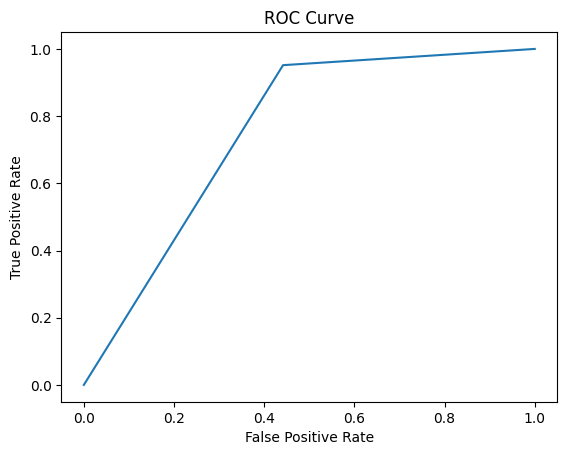

In [76]:
showresults(LRClassifier, 1)

Cutoff: 2
Logistic Regression: 
Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.5725021340335564 {'C': 0.01}
CVscore: means to params:  0.7899177307777381 {'C': 0.1}
CVscore: means to params:  0.846371446134411 {'C': 1}
CVscore: means to params:  0.8519241182898443 {'C': 10}
CVscore: means to params:  0.8519145071616754 {'C': 100}
Best hyperparameters: {'C': 10}
Confusion Matrix:
 [[ 948  235]
 [ 177 1559]]
Report on Validation Set: 
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      1183
           1       0.87      0.90      0.88      1736

    accuracy                           0.86      2919
   macro avg       0.86      0.85      0.85      2919
weighted avg       0.86      0.86      0.86      2919

Accuracy: 0.8588557725248372
Macro F1 score: 0.8523882934588891
ROC AUC: 0.8496969841572819


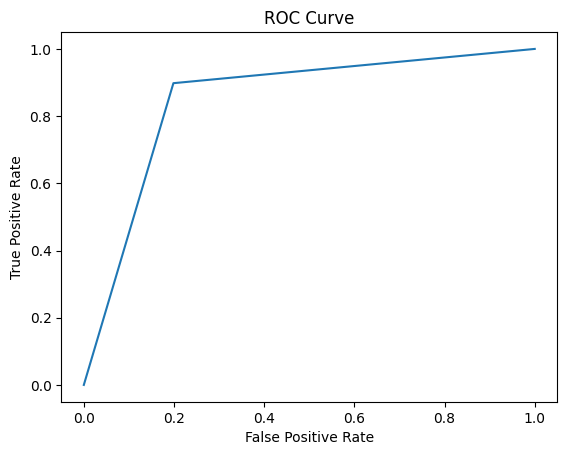

In [57]:
showresults(LRClassifier, 2)

Cutoff: 3
Logistic Regression: 
Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.5952225541484333 {'C': 0.01}
CVscore: means to params:  0.7685639750691229 {'C': 0.1}
CVscore: means to params:  0.8550767573421061 {'C': 1}
CVscore: means to params:  0.8687331740575004 {'C': 10}
CVscore: means to params:  0.8686574653934682 {'C': 100}
Best hyperparameters: {'C': 10}
Confusion Matrix:
 [[1658  117]
 [ 227  917]]
Report on Validation Set: 
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      1775
           1       0.89      0.80      0.84      1144

    accuracy                           0.88      2919
   macro avg       0.88      0.87      0.87      2919
weighted avg       0.88      0.88      0.88      2919

Accuracy: 0.882151421719767
Macro F1 score: 0.8740339309638863
ROC AUC: 0.8678289668078402


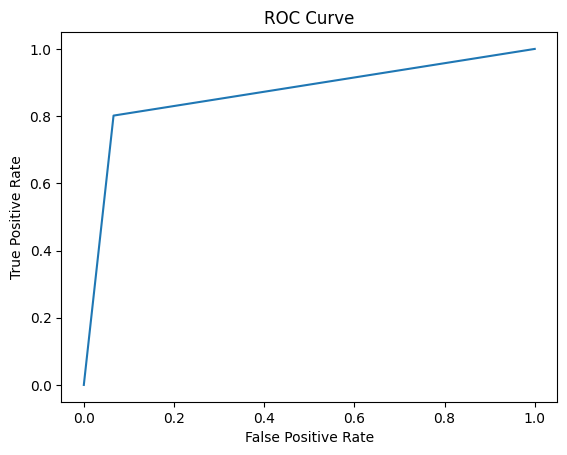

In [63]:
showresults(LRClassifier, 3)

Cutoff: 4
Logistic Regression: 
Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.6645747690442596 {'C': 0.01}
CVscore: means to params:  0.6921019514793387 {'C': 0.1}
CVscore: means to params:  0.7735772973005178 {'C': 1}
CVscore: means to params:  0.8006514343369989 {'C': 10}
CVscore: means to params:  0.8078458353517824 {'C': 100}
Best hyperparameters: {'C': 100}
Confusion Matrix:
 [[2286   77]
 [ 218  338]]
Report on Validation Set: 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      2363
           1       0.81      0.61      0.70       556

    accuracy                           0.90      2919
   macro avg       0.86      0.79      0.82      2919
weighted avg       0.89      0.90      0.89      2919

Accuracy: 0.8989379924631723
Macro F1 score: 0.8177886042679666
ROC AUC: 0.7876639864578924


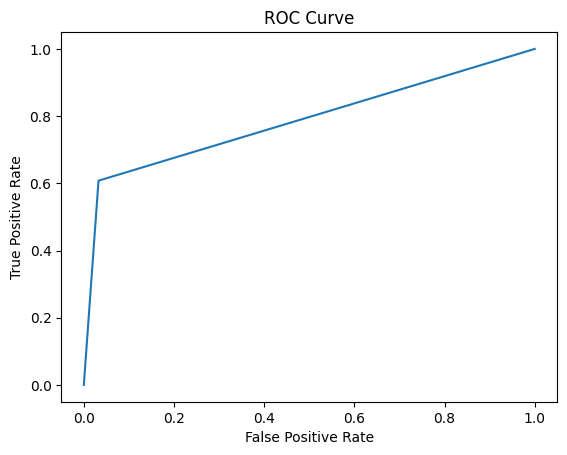

In [66]:
showresults(LRClassifier, 4)

Cutoff: 1
Naive Bayes:
Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.7105997372760645 {'alpha': 1e-05}
CVscore: means to params:  0.7371959375707133 {'alpha': 0.0001}
CVscore: means to params:  0.7529399833932222 {'alpha': 0.001}
CVscore: means to params:  0.7233061798237171 {'alpha': 0.01}
CVscore: means to params:  0.682305450429564 {'alpha': 0.1}
CVscore: means to params:  0.5786595722143334 {'alpha': 1}
CVscore: means to params:  0.5284206007466166 {'alpha': 10}
Best hyperparameters: {'alpha': 0.001}
Training model using best hyperparameters....
Evaluating model...
Confusion Matrix:
 [[ 788  445]
 [ 525 4080]]
Report on Validation Set: 
               precision    recall  f1-score   support

           0       0.60      0.64      0.62      1233
           1       0.90      0.89      0.89      4605

    accuracy                           0.83      5838
   macro avg       0.75      0.76      0.76      5838
weighted avg       0.84      0.83      0.84      5838



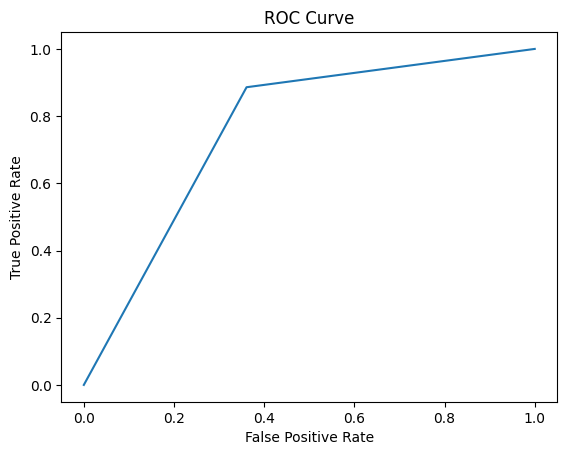

ROC AUC: 0.762542565866468


In [37]:
showresults(NBClassifier, 1)

Cutoff: 2
Naive Bayes:
Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.7760778356276046 {'alpha': 1e-05}
CVscore: means to params:  0.7894840509616253 {'alpha': 0.0001}
CVscore: means to params:  0.8049048530420319 {'alpha': 0.001}
CVscore: means to params:  0.8185525192710429 {'alpha': 0.01}
CVscore: means to params:  0.831802963008297 {'alpha': 0.1}
CVscore: means to params:  0.6592945055817487 {'alpha': 1}
CVscore: means to params:  0.5468664298759665 {'alpha': 10}
Best hyperparameters: {'alpha': 0.1}
Training model using best hyperparameters....
Evaluating model...
Confusion Matrix:
 [[1875  506]
 [ 408 3049]]
Report on Validation Set: 
               precision    recall  f1-score   support

           0       0.82      0.79      0.80      2381
           1       0.86      0.88      0.87      3457

    accuracy                           0.84      5838
   macro avg       0.84      0.83      0.84      5838
weighted avg       0.84      0.84      0.84      5838

Ac

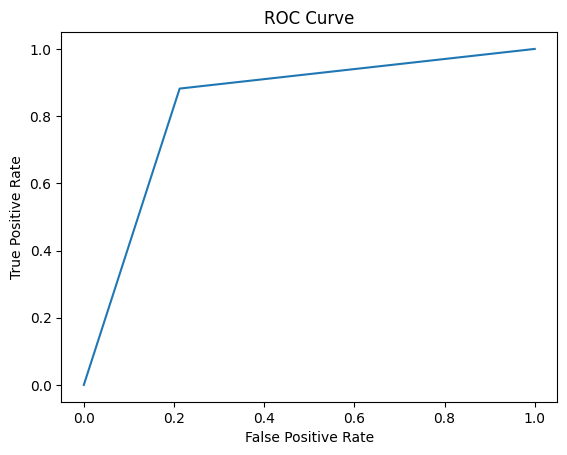

ROC AUC: 0.8347314222358886


In [38]:
showresults(NBClassifier, 2)

Cutoff: 3
Naive Bayes:
Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.7867202977219862 {'alpha': 1e-05}
CVscore: means to params:  0.8037059206096124 {'alpha': 0.0001}
CVscore: means to params:  0.821978586457201 {'alpha': 0.001}
CVscore: means to params:  0.8338814739762201 {'alpha': 0.01}
CVscore: means to params:  0.8354998133653264 {'alpha': 0.1}
CVscore: means to params:  0.6303806251336009 {'alpha': 1}
CVscore: means to params:  0.5844171482223526 {'alpha': 10}
Best hyperparameters: {'alpha': 0.1}
Training model using best hyperparameters....
Evaluating model...
Confusion Matrix:
 [[3337  239]
 [ 523 1739]]
Report on Validation Set: 
               precision    recall  f1-score   support

           0       0.86      0.93      0.90      3576
           1       0.88      0.77      0.82      2262

    accuracy                           0.87      5838
   macro avg       0.87      0.85      0.86      5838
weighted avg       0.87      0.87      0.87      5838

Ac

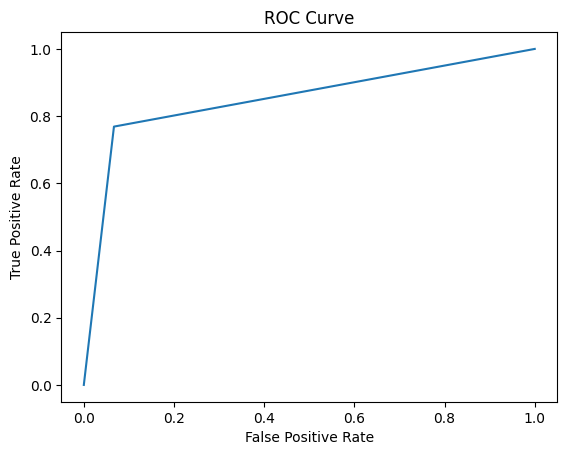

ROC AUC: 0.8509771153401099


In [39]:
showresults(NBClassifier, 3)

Cutoff: 4
Naive Bayes:
Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.737560321790107 {'alpha': 1e-05}
CVscore: means to params:  0.7618133662767441 {'alpha': 0.0001}
CVscore: means to params:  0.7702973902882648 {'alpha': 0.001}
CVscore: means to params:  0.7474548684083968 {'alpha': 0.01}
CVscore: means to params:  0.6979766662130185 {'alpha': 0.1}
CVscore: means to params:  0.6194311826829039 {'alpha': 1}
CVscore: means to params:  0.4748193317856053 {'alpha': 10}
Best hyperparameters: {'alpha': 0.001}
Training model using best hyperparameters....
Evaluating model...
Confusion Matrix:
 [[4275  430]
 [ 341  792]]
Report on Validation Set: 
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      4705
           1       0.65      0.70      0.67      1133

    accuracy                           0.87      5838
   macro avg       0.79      0.80      0.79      5838
weighted avg       0.87      0.87      0.87      5838



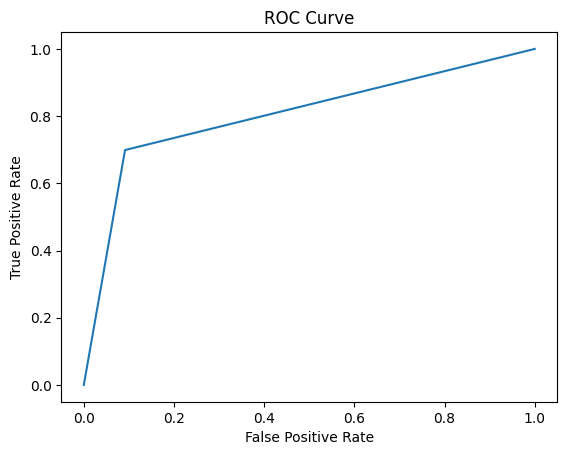

ROC AUC: 0.8038184950940438


In [40]:
showresults(NBClassifier, 4)

Cutoff: 1
Perceptron:
Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.7651162737836776 {'class_weight': None}
CVscore: means to params:  0.7813108796145576 {'class_weight': 'balanced'}
CVscore: means to params:  0.7614079253274338 {'class_weight': {0: 1, 1: 10}}
Best hyperparameters: {'class_weight': 'balanced'}
Training model using best hyperparameters....
Evaluating model...
Confusion Matrix:
 [[ 800  433]
 [ 378 4227]]
Report on Validation Set: 
               precision    recall  f1-score   support

           0       0.68      0.65      0.66      1233
           1       0.91      0.92      0.91      4605

    accuracy                           0.86      5838
   macro avg       0.79      0.78      0.79      5838
weighted avg       0.86      0.86      0.86      5838

Accuracy: 0.8610825625214115
Macro F1 score: 0.7880456613788709


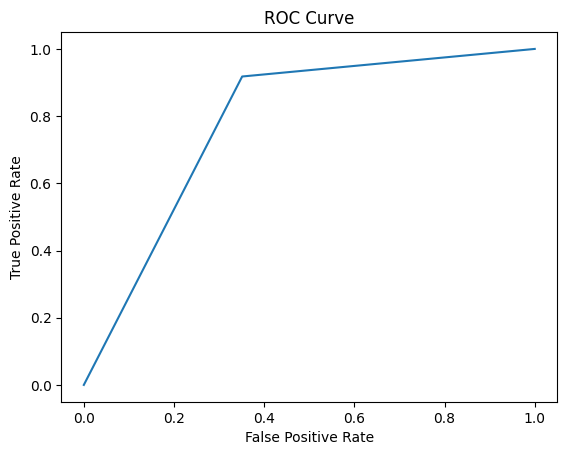

ROC AUC: 0.7833696579672471


In [41]:
showresults(Perceptron_Classifier, 1)

Cutoff: 2
Perceptron:
Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.8387302704655573 {'class_weight': None}
CVscore: means to params:  0.8402829480068895 {'class_weight': 'balanced'}
CVscore: means to params:  0.8310281685920264 {'class_weight': {0: 1, 1: 10}}
Best hyperparameters: {'class_weight': 'balanced'}
Training model using best hyperparameters....
Evaluating model...
Confusion Matrix:
 [[1989  392]
 [ 549 2908]]
Report on Validation Set: 
               precision    recall  f1-score   support

           0       0.78      0.84      0.81      2381
           1       0.88      0.84      0.86      3457

    accuracy                           0.84      5838
   macro avg       0.83      0.84      0.83      5838
weighted avg       0.84      0.84      0.84      5838

Accuracy: 0.8388146625556697
Macro F1 score: 0.8347189844731355


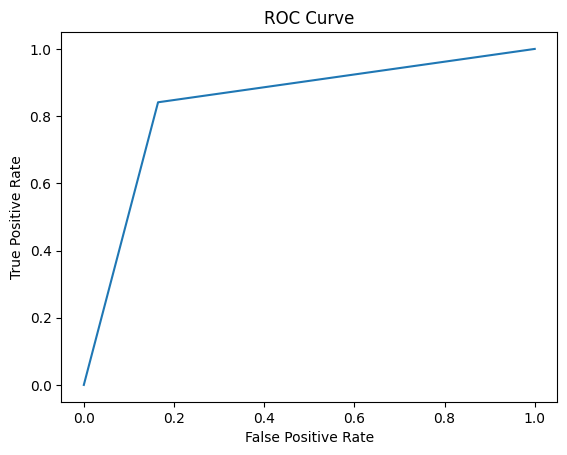

ROC AUC: 0.8382775387593202


In [42]:
showresults(Perceptron_Classifier, 2)

Cutoff: 3
Perceptron:
Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.8558756840460706 {'class_weight': None}
CVscore: means to params:  0.8454496574220386 {'class_weight': 'balanced'}
CVscore: means to params:  0.8521915655369272 {'class_weight': {0: 1, 1: 10}}
Best hyperparameters: {'class_weight': None}
Training model using best hyperparameters....
Evaluating model...
Confusion Matrix:
 [[3023  553]
 [ 233 2029]]
Report on Validation Set: 
               precision    recall  f1-score   support

           0       0.93      0.85      0.88      3576
           1       0.79      0.90      0.84      2262

    accuracy                           0.87      5838
   macro avg       0.86      0.87      0.86      5838
weighted avg       0.87      0.87      0.87      5838

Accuracy: 0.8653648509763617
Macro F1 score: 0.8613452843470373


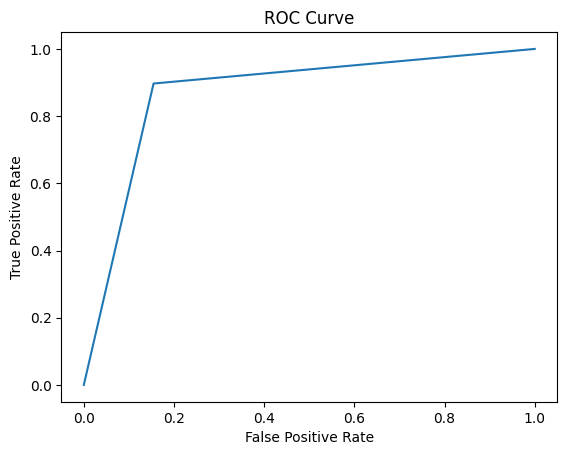

ROC AUC: 0.871175876310683


In [43]:
showresults(Perceptron_Classifier, 3)

Cutoff: 4
Perceptron:
Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.796420891274788 {'class_weight': None}
CVscore: means to params:  0.804986597026644 {'class_weight': 'balanced'}
CVscore: means to params:  0.8098840620053455 {'class_weight': {0: 1, 1: 10}}
Best hyperparameters: {'class_weight': {0: 1, 1: 10}}
Training model using best hyperparameters....
Evaluating model...
Confusion Matrix:
 [[4493  212]
 [ 399  734]]
Report on Validation Set: 
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      4705
           1       0.78      0.65      0.71      1133

    accuracy                           0.90      5838
   macro avg       0.85      0.80      0.82      5838
weighted avg       0.89      0.90      0.89      5838

Accuracy: 0.895340870161014
Macro F1 score: 0.8212214886175497


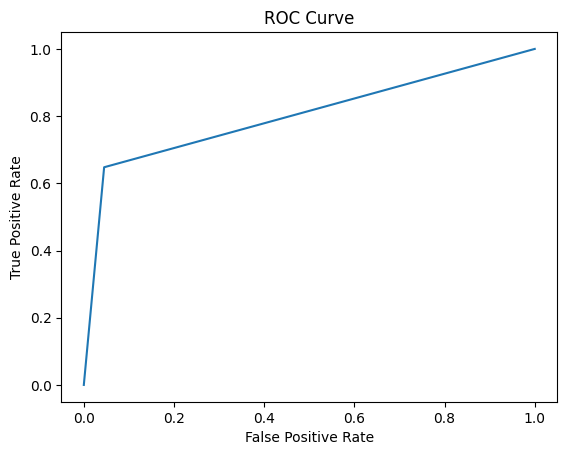

ROC AUC: 0.801389575417412


In [44]:
showresults(Perceptron_Classifier, 4)

# **Multiclass Classification**

In [45]:
def evaluate_multi(y_test, y_pred, y_proba):
    #evaluations
    confusion = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print('Confusion matrix:\n', confusion)
    print('Report: \n', classification_report(y_test, y_pred))
    print('Macro F1 score:', f1)
    
    # plot ROC curve for each class
    classes = np.unique(y_test)
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test==classes[i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        print('ROC AUC for class', str(classes[i])+':', roc_auc)
        plt.plot(fpr, tpr, lw=2, label='Class {}'.format(classes[i]))
    # plotting average curve
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test==classes[i], y_proba[:, i])
        mean_tpr.append(np.interp(mean_fpr, fpr, tpr))
    mean_tpr = np.mean(mean_tpr, axis=0)  # get mean of classes
    plt.plot(mean_fpr, mean_tpr, '--k', color='black', lw=2, label='Average')
    #graph labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    

In [46]:
# LR Classifier for Multiclass
def LRMulti():
    X_train, X_test, y_train, y_test = train_test_split(train_vectors, train_data['overall'], test_size=0.05, random_state=42)

    # params for multi class
    lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

    #evaluations 
    grid = tune_parameters(lr, param_grid, X_train, y_train) # fitting/ reporting hyperparameters & cv score
    best_clf = grid.best_estimator_
    y_pred = grid.predict(X_test) # get prediction off grid
    y_proba = best_clf.predict_proba(X_test) # get probability array for roc curves
    evaluate_multi(y_test, y_pred, y_proba)
    
    kag_pred = grid.predict(Kaggle_test_vectors)
    return kag_pred



In [47]:
# Naive Bayes for Multiclass
def NBMulti() :
    X_train, X_test, y_train, y_test = train_test_split(train_vectors, train_data['overall'], test_size=0.1)
    nb = MultinomialNB()
    param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}
    #evaluations 
    grid = tune_parameters(nb, param_grid, X_train, y_train) # fitting/ reporting hyperparameters & cv score
    best_clf = grid.best_estimator_
    y_pred = grid.predict(X_test) # get prediction off grid
    y_prob = best_clf.predict_proba(X_test)
    evaluate_multi(y_test, y_pred, y_prob)
    kag_pred = grid.predict(Kaggle_test_vectors)
    return kag_pred


In [48]:
# SGD Classifier for Multiclass
def SGDMulti():

    X_train, X_test, y_train, y_test = train_test_split(train_vectors, train_data['overall'], test_size=0.2, random_state=42)

    
    sgd = SGDClassifier(loss='log', max_iter=1000, tol=1e-3) # recommended parameters for multi-class
    param_grid = {'alpha': [0.00001, 0.0001, 0.001], 'tol': [1e-5, 1e-6, 1e-7]} # parameters to tune


    #evaluations
    grid = tune_parameters(sgd, param_grid, X_train, y_train) # fitting/ reporting hyperparameters & cv score
    best_clf = grid.best_estimator_
    y_pred = grid.predict(X_test) # get prediction off grid
    y_prob = best_clf.predict_proba(X_test)
    evaluate_multi(y_test, y_pred, y_prob)
    
    kag_pred = grid.predict(Kaggle_test_vectors)
    return kag_pred

In [52]:
def showMultiresults(funct):
    test_predicted = funct()
    test_ids = list(test_data.index)
    test_submission = pd.DataFrame({'id':test_ids, 'predicted':test_predicted})
    test_submission.head()
    test_submission.to_csv(str(funct.__name__)+ 'test_submission_part_multi.csv', index=False)

Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.41289302469617245 {'C': 0.001}
CVscore: means to params:  0.5084794410173865 {'C': 0.01}
CVscore: means to params:  0.5784852630944336 {'C': 0.1}
CVscore: means to params:  0.6053483944276788 {'C': 1}
CVscore: means to params:  0.5933315671066701 {'C': 10}
Best hyperparameters: {'C': 1}
Confusion matrix:
 [[220  66  12   4   5]
 [ 81 143  50  23   2]
 [ 26  62 153  42  10]
 [  7  14  43 165  58]
 [  9   6   7  43 209]]
Report: 
               precision    recall  f1-score   support

           1       0.64      0.72      0.68       307
           2       0.49      0.48      0.48       299
           3       0.58      0.52      0.55       293
           4       0.60      0.57      0.59       287
           5       0.74      0.76      0.75       274

    accuracy                           0.61      1460
   macro avg       0.61      0.61      0.61      1460
weighted avg       0.61      0.61      0.61      1460

Macro F1 

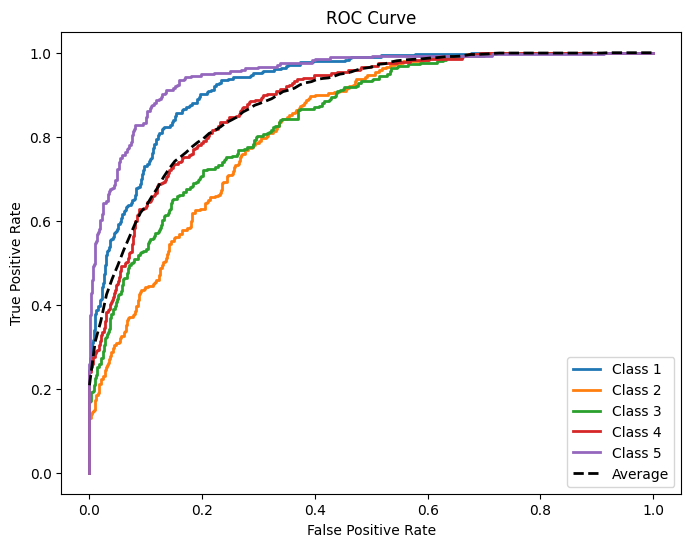

In [58]:
showMultiresults(LRMulti)

Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.5272907950396913 {'alpha': 0.0001}
CVscore: means to params:  0.5442009681669713 {'alpha': 0.001}
CVscore: means to params:  0.5659388412363291 {'alpha': 0.01}
CVscore: means to params:  0.5823046732005946 {'alpha': 0.1}
CVscore: means to params:  0.5825870911897766 {'alpha': 0.5}
CVscore: means to params:  0.5828502299338828 {'alpha': 1.0}
CVscore: means to params:  0.5687918290248659 {'alpha': 5.0}
CVscore: means to params:  0.5579678685137714 {'alpha': 10.0}
Best hyperparameters: {'alpha': 1.0}
Confusion matrix:
 [[377 173  29   3   4]
 [131 357 107  21   0]
 [ 36 163 307  74   3]
 [ 21  58 114 361  44]
 [ 16  43  27 153 297]]
Report: 
               precision    recall  f1-score   support

           1       0.65      0.64      0.65       586
           2       0.45      0.58      0.51       616
           3       0.53      0.53      0.53       583
           4       0.59      0.60      0.60       598
           5

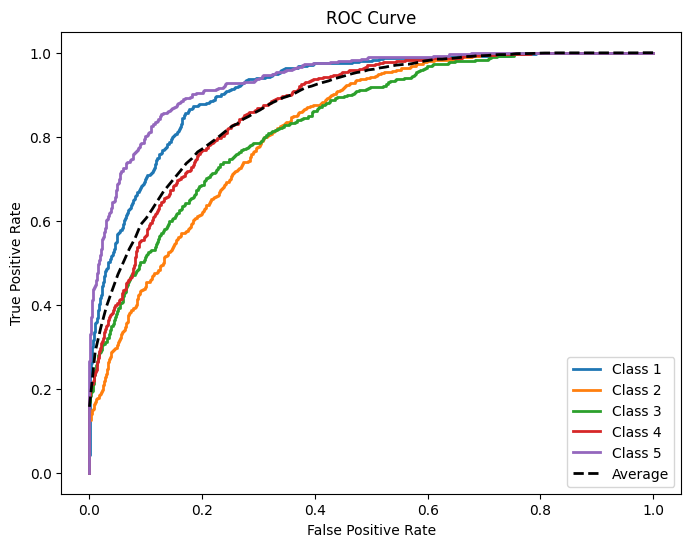

In [65]:
showMultiresults(NBMulti)

Fitting Grid for Tuning....
Grid fitted
CVscore: means to params:  0.5842861575553033 {'alpha': 1e-05, 'tol': 1e-05}
CVscore: means to params:  0.5830993547744179 {'alpha': 1e-05, 'tol': 1e-06}
CVscore: means to params:  0.5780209730051296 {'alpha': 1e-05, 'tol': 1e-07}
CVscore: means to params:  0.5898240920032657 {'alpha': 0.0001, 'tol': 1e-05}
CVscore: means to params:  0.5929494207037616 {'alpha': 0.0001, 'tol': 1e-06}
CVscore: means to params:  0.5914169335654493 {'alpha': 0.0001, 'tol': 1e-07}
CVscore: means to params:  0.5511599692047591 {'alpha': 0.001, 'tol': 1e-05}
CVscore: means to params:  0.5504564823568268 {'alpha': 0.001, 'tol': 1e-06}
CVscore: means to params:  0.5520229865974383 {'alpha': 0.001, 'tol': 1e-07}
Best hyperparameters: {'alpha': 0.0001, 'tol': 1e-06}
Confusion matrix:
 [[901 230  58  23  21]
 [355 542 155  71  25]
 [124 212 591 224  44]
 [ 57  64 126 699 183]
 [ 59  31  36 197 810]]
Report: 
               precision    recall  f1-score   support

          

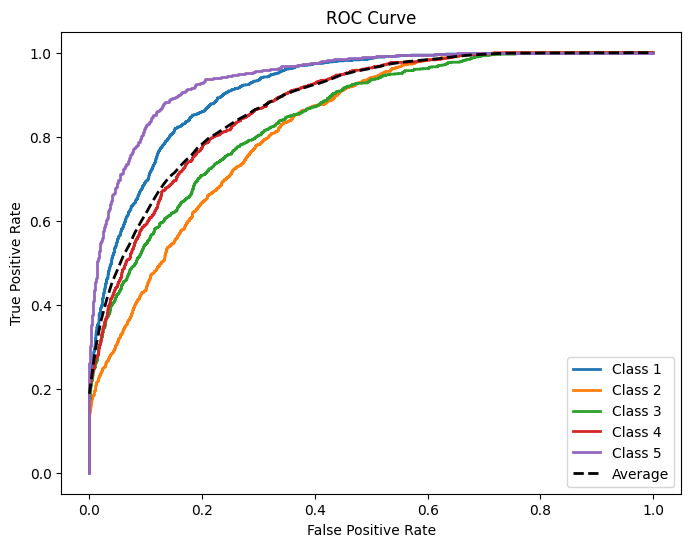

In [60]:
showMultiresults(SGDMulti)

### **K-Means CLUSTERING TO DETERMINE PRODUCT TYPES**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score


In [ ]:
def k_means_cluster(n):
    # get review vector
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=0.1, ngram_range=(1,3), max_features=10)
    cluster_vector = tfidf_vectorizer.fit_transform(test_data['reviewText'])
    # perform k-means clustering
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(cluster_vector)

    # evaluate clustering using Silhouette score and Rand index
    clust = kmeans.predict(cluster_vector)
    silhouette = silhouette_score(cluster_vector, clust)

    rand_index = adjusted_rand_score(test_data['category'], clust) 
    print(f'Silhouette score: {silhouette}')
    print(f'Rand index: {rand_index}')




In [ ]:
k_means_cluster(6)

Silhouette score: 0.5983435076392746
Rand index: 0.010637113362011638
